In [1]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from src.parser import *
from src.metrics import *

# Task 2.1: Adaptative modeling

## Read video

In [2]:
# file_path = "../datasets/AICity_data/AICity_data/train/S03/c010/vdo.avi"
file_path = 'C:/Users/Marcos/Desktop/Master Computer Vision/M6/Project/Work final/mcv-m6-2023-team4/datasets/AICity_data/train/S03/c010/vdo.avi'

cap = cv2.VideoCapture(file_path)

start_plot = 0
# end_plot = 100
end_plot = np.Inf

video_frames = []
index = 0

while True:
    ret, frame = cap.read()


    if not ret:
        break


    if index < end_plot:
        
        #video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        
    else:
        break

    index += 1


cap.release()

end_plot = min(end_plot, index)

## Model the background with the first 25% of the sequence
First 25 % frames for training

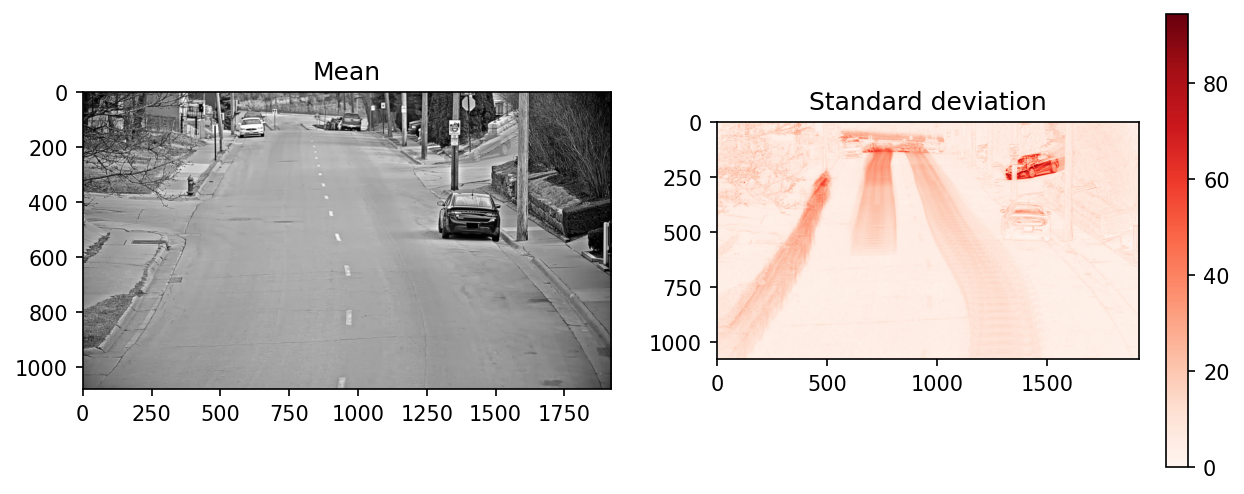

In [3]:
video_frames_arr = np.array(video_frames)

p1 = int(0.25*end_plot)

mean = np.mean(video_frames_arr[0:p1], axis=0)
std = np.std(video_frames_arr[0:p1], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10,8), dpi=150)
ax[0].imshow(mean, cmap='gray')
ax[0].set_title("Mean")
std_img = ax[1].imshow(std, cmap='Reds')
fig.colorbar(std_img, shrink=0.5)
ax[1].set_title("Standard deviation")
fig.show()

## Segment the foreground and background of the remaining 75% of the sequence

In [16]:
alpha = 5
rho = 0.2

mean = np.mean(video_frames_arr[0:p1], axis=0)
std = np.std(video_frames_arr[0:p1], axis=0)

video_frames_out = []
index = 0
for frame in video_frames_arr[p1:]:
    s = np.where(np.abs(frame - mean) >= alpha * (std + 2), 255, 0).astype("uint8")
    
    # # Update mean and variance
    mean_background = rho*frame + (1-rho)*mean
    # We need the square root of the standard deviation
    std_background = np.sqrt(rho*np.square(frame-mean) + (1-rho)*np.square(std))
    
    mean[np.where(s==0)] = mean_background[np.where(s==0)]
    std[np.where(s==0)] = std_background[np.where(s==0)]
    
    video_frames_out.append(Image.fromarray(s))
    
    if index % 200 == 0:
        print(index)
    if index > 600:
        break
    index+=1
    
video_frames_out[0].save("Task2.1.gif", save_all=True, append_images=video_frames_out[1:250], duration=30, loop=0)

0
200
400
600


### Saving gif with some initial alpha

In [3]:
alpha = 5

video_frames_out = []
for frame in video_frames_arr[p1:]:
    s = np.where(np.abs(frame - mean) >= alpha * (std + 2), 255, 0).astype("uint8")
    
    video_frames_out.append(Image.fromarray(s))
    
video_frames_out[0].save("Task1.1.gif", save_all=True, append_images=video_frames_out[1:250], duration=30, loop=0)

In [ ]:
alpha = 1.75
rho = 0.3981

mean = np.mean(video_frames_arr[0:p1], axis=0)
std = np.std(video_frames_arr[0:p1], axis=0)

video_frames_out = []
index = 0
for frame in video_frames_arr[p1:]:
    s = np.where(np.abs(frame - mean) >= alpha * (std + 2), 255, 0).astype("uint8")
    
    # # Update mean and variance
    frame_background = frame * ((255-s)/255)
    mean_background = mean * ((255-s)/255)
    std_background = std * ((255-s)/255)
    
    mean_background = rho*frame_background + (1-rho)*mean_background
    # We need the square root of the standard deviation
    std_background = np.sqrt(rho*np.square(frame_background-mean_background) + (1-rho)*np.square(std_background))
    
    
    mean[np.nonzero(frame_background)] = mean_background[np.nonzero(frame_background)]
    std[np.nonzero(frame_background)] = std_background[np.nonzero(frame_background)]
    
    video_frames_out.append(Image.fromarray(s))
    
    if index % 200 == 0:
        print(index)
    if index > 600:
        break
    index+=1
    
video_frames_out[0].save("Task2.1.gif", save_all=True, append_images=video_frames_out[1:250], duration=30, loop=0)

# Task 1.2: mAP@0.5 vs Alpha

## Getting connected components

### Segmenting foreground

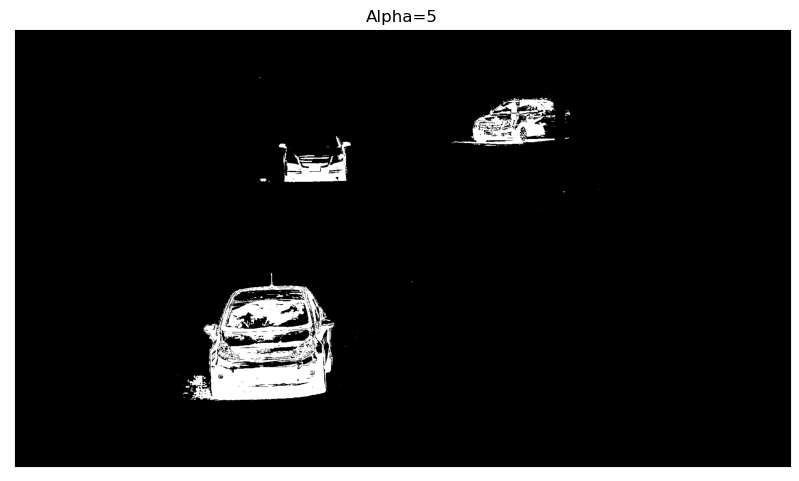

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=100)

s1 = np.where(np.abs(video_frames_arr[p1+15] - mean) >= alpha * (std + 2), 255, 0).astype("uint8")

ax.imshow(s1, cmap='gray')
ax.set_title("Alpha=" + str(alpha))
ax.set_xticks([], [])
ax.set_yticks([], [])

fig.show()

### Improve result with morphology

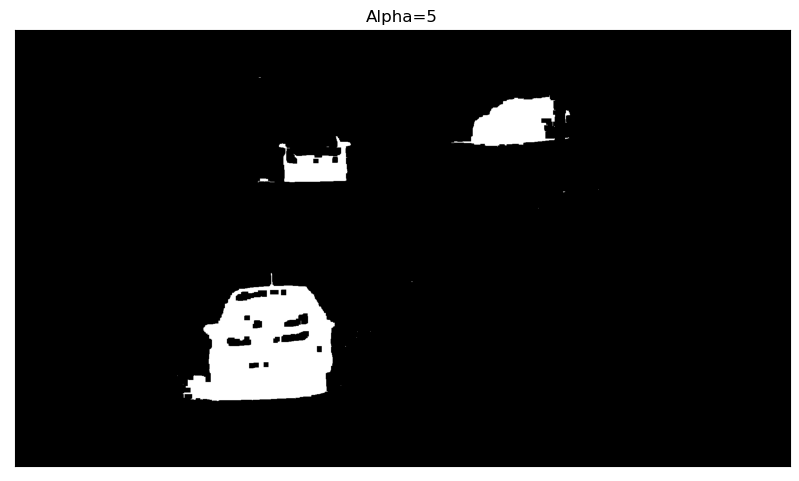

In [5]:
#s2 = cv2.morphologyEx(s1, cv2.MORPH_OPEN, np.ones((3,3)))
s2 = cv2.dilate(s1, np.ones((11,11)))
s2 = cv2.erode(s2, np.ones((11,11)))

fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=100)

ax.imshow(s2, cmap='gray')
ax.set_title("Alpha=" + str(alpha))
ax.set_xticks([], [])
ax.set_yticks([], [])

fig.show()

### Get connected components

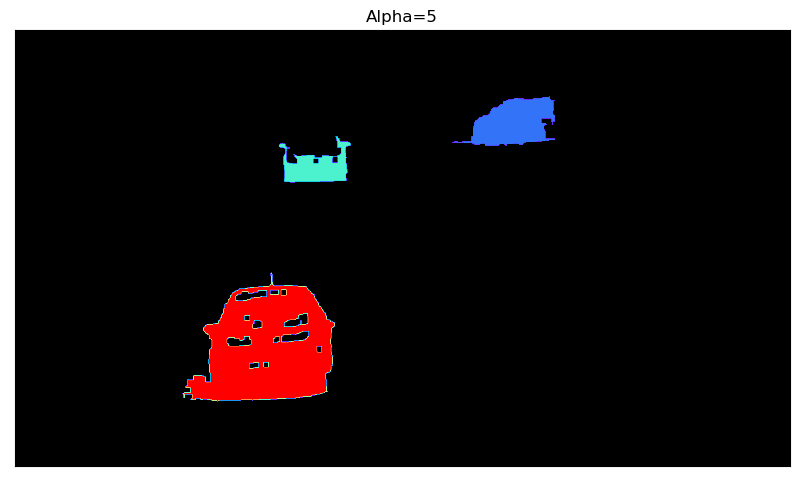

In [6]:
num_labels, labels_im = cv2.connectedComponents(s2)

# Remove very small objects
values, counts = np.unique(labels_im, return_counts=True)
values_small = np.unique(np.where(counts < np.sum(counts)*0.0001, values, 0))

labels_im_2 = labels_im.copy()

for value in values_small:
    labels_im_2 = np.where(labels_im_2==value, 0, labels_im_2)

cmap = cm.get_cmap('rainbow', num_labels)
newcolors = cmap(np.linspace(0, 1, num_labels))
black = np.array([0, 0, 0, 1])
newcolors[0] = black
newcmap = ListedColormap(newcolors)

fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=100)

ax.imshow(labels_im_2, cmap=newcmap)
ax.set_title("Alpha=" + str(alpha))
ax.set_xticks([], [])
ax.set_yticks([], [])

fig.show()

### Get bounding boxes of connected components

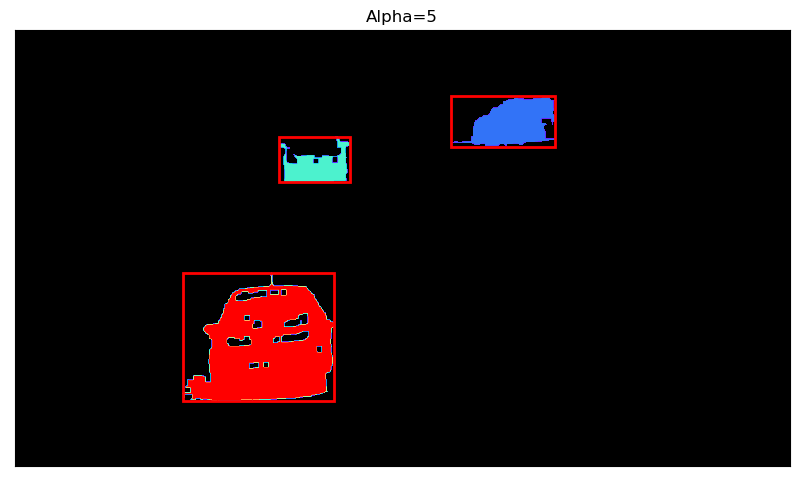

In [7]:
im_objects = np.unique(labels_im_2)

cmap = cm.get_cmap('rainbow', num_labels)
newcolors = cmap(np.linspace(0, 1, num_labels))
black = np.array([0, 0, 0, 1])
newcolors[0] = black
newcmap = ListedColormap(newcolors)

fig, ax = plt.subplots(1, 1, figsize=(10,8), dpi=100)

ax.imshow(labels_im_2, cmap=newcmap)
ax.set_title("Alpha=" + str(alpha))
ax.set_xticks([], [])
ax.set_yticks([], [])

bboxes = []

for im_object_id in im_objects:
    
    if im_object_id == 0:
        continue # skip background
    
    object_im = np.where(labels_im_2==im_object_id, 1, 0)
    
    object_region = np.where(object_im != 0)
    bboxes.append([np.min(object_region[0]), np.max(object_region[0]),
                  np.min(object_region[1]), np.max(object_region[1])])
    
    ax.add_patch(patches.Rectangle((bboxes[-1][2], bboxes[-1][0]),
                                   bboxes[-1][3] - bboxes[-1][2], 
                                   bboxes[-1][1] - bboxes[-1][0],
                                   linewidth=2, edgecolor='r', facecolor='none'))

    
fig.show()

### Extract bboxes GT from annotations

In [8]:
path_gt = "../datasets/AICity_data/AICity_data/train/S03/c010/gt/gt.txt"

bboxes_gt = parse_detection_txt(path_gt)

### Segmentation for all the frames

In [62]:
import pandas as pd

df = pd.DataFrame(columns=['alpha', 'mAP'])

alphas = [1, 5, 8, 10, 15]

results_alphas = {}

for alpha in alphas:
    
    print('Alpha=' + str(alpha))

    bboxes_pred = {}

    video_frames_out = []

    for frame_id, frame in enumerate(video_frames_arr[p1:]):

        s1 = np.where(np.abs(frame - mean) >= alpha * (std + 2), 255, 0).astype("uint8")



        s2 = cv2.dilate(s1, np.ones((11,11)))
        s2 = cv2.erode(s2, np.ones((11,11)))



        num_labels, labels_im = cv2.connectedComponents(s2)

        # Remove very small objects
        values, counts = np.unique(labels_im, return_counts=True)
        values_small = np.unique(np.where(counts < np.sum(counts)*0.01, values, 0))

        labels_im_2 = labels_im.copy()

        for value in values_small:
            labels_im_2 = np.where(labels_im_2==value, 0, labels_im_2)

        im_objects = np.unique(labels_im_2)



        bboxes_pred[frame_id + p1] = []

        for im_object_id in im_objects:

            if im_object_id == 0:
                continue # skip background

            object_im = np.where(labels_im_2==im_object_id, 1, 0)

            object_region = np.where(object_im != 0)    

            bboxes_pred[frame_id + p1].append({'xtl': np.min(object_region[1]),
                                       'ytl': np.min(object_region[0]),
                                       'xbr': np.max(object_region[1]),
                                       'ybr': np.max(object_region[0]),
                                       'outside': None,
                                       'occluded': None,
                                       'keyframe': None,
                                       'parked': None,
                                       'predicted': True,
                                       'detected': False,
                                       'confidence': 1.0})  



    rec, prec, mAP = voc_eval(bboxes_gt, bboxes_pred)

    print('mAP:', round(mAP, 4), '\n-----------------')

    df = df.append({'alpha': alpha, 'mAP': round(mAP, 4)}, ignore_index=True)
    
    results_alphas[alpha] = {'mAP': mAP, 'bboxes_pred': bboxes_pred}

Alpha=1
mAP: 0.0 
-----------------
Alpha=5
mAP: 0.1339 
-----------------
Alpha=8
mAP: 0.2192 
-----------------
Alpha=10
mAP: 0.1599 
-----------------
Alpha=15
mAP: 0.0909 
-----------------


In [63]:
df

,alpha,mAP
0,1.0,0.0
1,5.0,0.1339
2,8.0,0.2192
3,10.0,0.1599
4,15.0,0.0909


In [64]:
d = df.to_numpy()
worst_alpha = d[np.argmin(d[:, 1], axis=0)][0]
best_alpha = d[np.argmax(d[:, 1], axis=0)][0]

print('Worst alpha:', worst_alpha)
print('Best alpha:', best_alpha)

Worst alpha: 1.0
Best alpha: 8.0


### Visual comparison of best and worst alpha

In [65]:
alphas = [worst_alpha, best_alpha]

video_frames_out = []
for frame in video_frames_arr[p1:]:

    fig, ax = plt.subplots(1, len(alphas), figsize=(10,8), dpi=100)

    for i, alpha in enumerate(alphas):

        s = np.where(np.abs(frame - mean) >= alpha * (std + 2), 255, 0).astype("uint8")

        ax[i].imshow(s, cmap='gray')
        ax[i].set_title("Alpha=" + str(alpha))
        ax[i].set_xticks([], [])
        ax[i].set_yticks([], [])


    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    frame_out = Image.fromarray(np.asarray(canvas.buffer_rgba()).astype("uint8"))
    
    video_frames_out.append(frame_out)
    
    canvas.get_renderer().clear()
    plt.close(fig)
    
video_frames_out[0].save("Task1.2.gif", save_all=True, append_images=video_frames_out[1:250], duration=30, loop=0)